Reproducing an example from here:

https://mne.tools/stable/auto_examples/decoding/plot_decoding_csp_eeg.html

converting np array to rawdata format:
https://mne.tools/stable/auto_examples/io/plot_objects_from_arrays.html#sphx-glr-auto-examples-io-plot-objects-from-arrays-py

## Experimenting and prototyping with this first section to get annotations with data

In [87]:
import pickle as pk

import mne
import pandas as pd
import numpy as np

In [88]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP


In [89]:
raw2 = mne.io.read_raw_edf('/home/nate/github/ssvep_test/win_exp1_ssvep/bluetooth/12_20/edf_data.edf')

Extracting EDF parameters from /home/nate/github/ssvep_test/win_exp1_ssvep/bluetooth/12_20/edf_data.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [90]:
with open('/home/nate/github/ssvep_test/win_exp1_ssvep/bluetooth/12_18/exp_1_12_18hz_alpha_times.pk', 'rb') as f:
    alpha_times = pk.load(f)

with open('/home/nate/github/ssvep_test/win_exp1_ssvep/bluetooth/12_18/exp_1_12_18hz_times.pk', 'rb') as f:
    yn_times = pk.load(f)
    
with open('/home/nate/github/ssvep_test/win_exp1_ssvep/bluetooth/12_18/exp_1_12_18hz_yes_nos.pk', 'rb') as f:
    yn = pk.load(f)
    
with open('/home/nate/github/ssvep_test/win_exp1_ssvep/bluetooth/12_18/first_timestamp.pk', 'rb') as f:
    first_ts = pk.load(f)

In [94]:
alpha_onsets = [a[0] - first_ts for a in alpha_times]
beta_onsets = [a[1] - first_ts for a in alpha_times]

In [95]:
alpha_durations = [a[1] - a[0] for a in alpha_times]
beta_durations = [a[0] - b[1] for a, b in zip(alpha_times[1:] + [tuple(yn_times[0])], alpha_times)]

In [96]:
yn_onsets = [y[0] - first_ts for y in yn_times]

In [97]:
yn_durations = [y[1] - y[0] for y in yn_times]

In [98]:
onsets = np.array(alpha_onsets + beta_onsets + yn_onsets)
durations = np.array(alpha_durations + beta_durations + yn_durations)
descriptions = np.array(['alpha'] * len(alpha_onsets) + ['beta'] * len(beta_onsets) + \
    ['yes' if y == True else 'no' for y in yn])

sorted_idx = np.argsort(onsets)

In [99]:
descriptions[sorted_idx]

array(['alpha', 'beta', 'alpha', 'beta', 'alpha', 'beta', 'alpha', 'beta',
       'alpha', 'beta', 'alpha', 'beta', 'yes', 'no', 'no', 'no', 'yes',
       'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes',
       'no', 'no', 'no', 'yes', 'no'], dtype='<U5')

In [100]:
annot = mne.Annotations(onsets[sorted_idx], durations[sorted_idx], descriptions[sorted_idx])

In [19]:
idx = 0
datapaths = ['/home/nate/github/ssvep_test/win_exp1_ssvep/bluetooth/12_18/',
            '/home/nate/github/ssvep_test/win_exp1_ssvep/bluetooth/12_20/',
            '/home/nate/github/ssvep_test/win_exp1_ssvep/bluetooth/10_20/',
            '/home/nate/github/ssvep_test/win_exp1_ssvep/wifi/']
filenames = ['exp_1_12_18hz_data.csv',
           'exp_1_12_20hz_data.csv',
            'exp_1_1020hz_data.csv',
            'exp_1_12_20hz_data.csv']

In [20]:
df = pd.read_csv(datapaths[idx] + filenames[idx])
df = df.iloc[500:]

/home/nate/anaconda3/envs/openbci/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [24]:
# dict with conversion from number to 10-20 location
number_to_1020 = {1: 'Fp1',
                 2: 'Fp2',
                 3: 'C3',
                 4: 'C4',
                 5: 'T5',
                 6: 'T6',
                 7: 'O1',
                 8: 'O2',
                 9: 'F7',
                 10: 'F8',
                 11: 'F3',
                 12: 'F4',
                 13: 'T3',
                 14: 'T4',
                 15: 'P3',
                 16: 'P4'}

ch_types = ['eeg'] * 16
ch_names = list(number_to_1020.values())

info = mne.create_info(ch_names=ch_names, sfreq=125, ch_types=ch_types)

raw = mne.io.RawArray(df[[str(i) for i in list(range(1, 17))]].values.T, info)

Creating RawArray with float64 data, n_channels=16, n_times=32445
    Range : 0 ... 32444 =      0.000 ...   259.552 secs
Ready.


In [25]:
raw.set_annotations(annot)

<RawArray | 16 x 32445 (259.6 s), ~4.0 MB, data loaded>

In [27]:
# attach 10-20 system to data labels
montage = make_standard_montage('standard_1020')
raw.set_montage(montage)

<RawArray | 16 x 32445 (259.6 s), ~4.0 MB, data loaded>

In [101]:
basepath = '/home/nate/github/ssvep_test/'
ssvep_bt_paths = ['win_exp1_ssvep/bluetooth/12_18/',
                  'win_exp1_ssvep/bluetooth/10_20/',
                  'win_exp1_ssvep/bluetooth/12_20/'
                 ]
ssvep_bt_datapaths = [basepath + p for p in ssvep_bt_paths]

ssvep_wifi_datapaths = [basepath + 'win_exp1_ssvep/wifi']

mi_bt_paths = [basepath + 'win_mi/r_l_imagined/',
              basepath + 'win_mi/r_l_actual_not_imagined/']

li_bt_paths = [basepath + 'win_li/imagined/',
              basepath + 'win_li/actual_not_imagined/']

In [29]:
import os

In [30]:
os.listdir(mi_bt_paths[0])

['mi_exp1_data.csv', 'mi_exp1_up_downs.pk', 'mi_exp1_times.pk']

In [103]:
def make_annotations(datapath, first_ts, annot_str='up_downs.pk', include_alpha=False, mi_li='mi'):
    """Makes an MNE annotation from pickle files with start/stop times for alpha and frequency times.
    
    Parameters
    ----------
    datapath : str
        path to data files
    first_ts : float
        first timestamp from data (in seconds since epoch)
    annot_str : str
        end of file with annotation labels in it (e.g. up/down)
    include_alpha : boolean
        If true, includes '*alpha_times.pk' file for alpha wave times
    """
    files = os.listdir(datapath)
    datafile = [f for f in files if 'data.csv' in f][0]
    times_file = [f for f in files if 'times.pk' in f][0]
    annot_file = [f for f in files if annot_str in f][0]
    yn_durations = [y[1] - y[0] for y in yn_times]

    with open(datapath + times_file, 'rb') as f:
        annot_times = pk.load(f)

    with open(datapath + annot_file, 'rb') as f:
        annot = pk.load(f)
        
    annot_onsets = [a[0] - first_ts for a in annot_times]
    annot_durations = [a[1] - a[0] for a in annot_times]

    if include_alpha:
        alpha_times_files = [f for f in files if 'alpha_times.pk' in f][0]
        with open(datapath + alpha_times_files, 'rb') as f:
            alpha_times = pk.load(f)
    
        alpha_onsets = [a[0] - first_ts for a in alpha_times]
        beta_onsets = [a[1] - first_ts for a in alpha_times]
        alpha_durations = [a[1] - a[0] for a in alpha_times]
        beta_durations = [a[0] - b[1] for a, b in zip(alpha_times[1:] + [tuple(annot_times[0])], alpha_times)]
        onsets = np.array(alpha_onsets + beta_onsets + annot_onsets)
        durations = np.array(alpha_durations + beta_durations + annot_durations)
        descriptions = np.array(['alpha'] * len(alpha_onsets) + ['beta'] * len(beta_onsets) + \
            ['yes' if y == True else 'no' for y in annot])

        sorted_idx = np.argsort(onsets)
        mne_annot = mne.Annotations(onsets[sorted_idx], durations[sorted_idx], descriptions[sorted_idx])
    else:
        onsets = np.array(annot_onsets)
        durations = np.array(annot_durations)
        if mi_li == 'mi':
            descriptions = np.array(['right' if a == True else 'left' for a in annot])
        elif mi_li == 'li':
            descriptions = np.array(['high' if a == True else 'low' for a in annot])
            
        mne_annot = mne.Annotations(onsets, durations, descriptions)
    
    return mne_annot

In [104]:
def convert_data_to_fif(datapath, sfreq=125, annot_str='up_downs.pk', include_alpha=False, mi_li='mi'):
    """Converts csv and pk files with data and annotation times to MNE raw fif file and object.
    """
    files = os.listdir(datapath)
    datafile = [f for f in files if 'data.csv' in f][0]
    df = pd.read_csv(datapath + datafile)
    df = df.iloc[2*sfreq:]
    if 'wifi' in datapath:
        df = df.iloc[:-2*sfreq]
    annot = make_annotations(datapath,
                             first_ts=df.iloc[0]['30'],
                             annot_str=annot_str,
                             include_alpha=include_alpha,
                             mi_li=mi_li)
    
    # dict with conversion from number to 10-20 location
    number_to_1020 = {1: 'Fp1',
                     2: 'Fp2',
                     3: 'C3',
                     4: 'C4',
                     5: 'T5',
                     6: 'T6',
                     7: 'O1',
                     8: 'O2',
                     9: 'F7',
                     10: 'F8',
                     11: 'F3',
                     12: 'F4',
                     13: 'T3',
                     14: 'T4',
                     15: 'P3',
                     16: 'P4'}

    ch_types = ['eeg'] * 16
    ch_names = list(number_to_1020.values())

    info = mne.create_info(ch_names=ch_names, sfreq=125, ch_types=ch_types)

    raw = mne.io.RawArray(df[[str(i) for i in list(range(1, 17))]].values.T, info)
    raw.set_annotations(annot)
    # attach 10-20 system to data labels
    montage = make_standard_montage('standard_1020')
    raw.set_montage(montage)
    
    raw.save(datapath + '_raw.fif.gz', overwrite=True)
    return raw

In [116]:
raw = convert_data_to_fif(datapath=li_bt_paths[1], annot_str='hi_lows.pk', mi_li='li')

Creating RawArray with float64 data, n_channels=16, n_times=26023
    Range : 0 ... 26022 =      0.000 ...   208.176 secs
Ready.
Overwriting existing file.
Writing /media/nate/storage/github/ssvep_test/win_li/actual_not_imagined/_raw.fif.gz
Closing /media/nate/storage/github/ssvep_test/win_li/actual_not_imagined/_raw.fif.gz [done]


In [117]:
# raw = convert_data_to_fif(datapath='/home/nate/github/ssvep_test/win_mi/wifi/imagined/2-10 trial/',
#                          sfreq=1000)

In [118]:
raw.annotations.description

array(['low', 'low', 'low', 'low', 'low', 'low', 'high', 'high', 'high',
       'low', 'high', 'low', 'high', 'high', 'low', 'low', 'high', 'high',
       'high', 'high'], dtype='<U4')

In [119]:
tmin, tmax = -1., 5.
event_id = dict(high=1, low=0)

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

events, _ = events_from_annotations(raw, event_id=dict(high=1, low=0))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=0.5, tmax=2.)
labels = epochs.events[:, -1] - 2

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 sec)

Used Annotations descriptions: ['high', 'low']
20 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 20 events and 751 original time points ...
0 bad epochs dropped


In [120]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Computing rank from data with rank=None
    Using tolerance 2.5 (2.2e-16 eps * 16 dim * 6.9e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7 (2.2e-16 eps * 16 dim * 7.7e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 16 dim * 7.4e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 16 dim * 7.2e+14  max singular value)
    Estimated ra

Computing rank from data with rank=None
    Using tolerance 5.9 (2.2e-16 eps * 16 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.7 (2.2e-16 eps * 16 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.


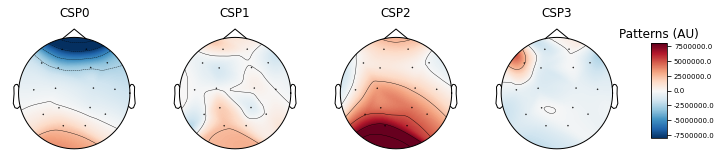

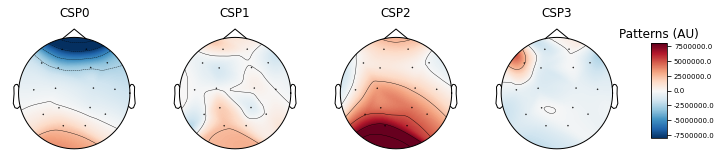

In [121]:
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

In [ ]:
raw.filter(7., 30.)

In [ ]:
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

In [75]:
raw2.annotations.onset

array([1.37434000e-01, 5.13882600e+00, 1.01739810e+01, 1.51751740e+01,
       2.02044460e+01, 2.52061340e+01, 3.02339590e+01, 3.52354340e+01,
       4.02641130e+01, 4.52653360e+01, 5.02938010e+01, 5.52950530e+01,
       6.03390860e+01, 7.03855500e+01, 8.04327150e+01, 9.04787220e+01,
       1.00525312e+02, 1.10571965e+02, 1.20619106e+02, 1.30664840e+02,
       1.40712370e+02, 1.50758305e+02, 1.60805387e+02, 1.70851884e+02,
       1.80898579e+02, 1.90945074e+02, 2.00991340e+02, 2.11038319e+02,
       2.21085054e+02, 2.31131120e+02, 2.41177103e+02, 2.51223957e+02])

In [78]:
raw2.save('test.raw.fif.gz')

Writing /media/nate/storage/github/ssvep_test/test.raw.fif.gz
Closing /media/nate/storage/github/ssvep_test/test.raw.fif.gz [done]


In [40]:
sfreq = 1000  # Sampling frequency

# Definition of channel types and names.
ch_types = ['eeg'] * 16
ch_names = [str(i) for i in range(1, 17)]

In [42]:
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

In [45]:
raw = mne.io.RawArray(df[ch_names].T, info)

Creating RawArray with float64 data, n_channels=16, n_times=258098
    Range : 0 ... 258097 =      0.000 ...   258.097 secs
Ready.


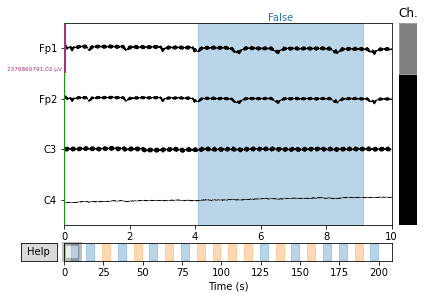

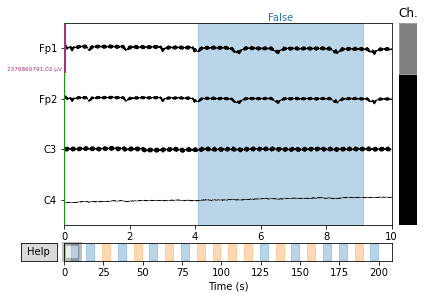

In [42]:
scalings = 'auto'  # Could also pass a dictionary with some value == 'auto'
raw.plot(n_channels=4, scalings=scalings, title='Auto-scaled Data from arrays',
         show=True, block=True)

In [2]:
f = raw_fnames[0]

In [3]:
f

'/home/nate/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf'

In [4]:
d = read_raw_edf(f, preload=True)

Extracting EDF parameters from /home/nate/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [6]:
type(d)

mne.io.edf.edf.RawEDF

In [ ]:
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

In [7]:
raw

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.5 MB, data loaded>

In [47]:
montage = make_standard_montage('standard_1005')

In [56]:
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

Extracting EDF parameters from /home/nate/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/nate/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/nate/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [66]:
raw.annotations.description

array(['T0', 'T2', 'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T1', 'T0',
       'T2', 'T0', 'T2', 'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T2',
       'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T2', 'BAD boundary',
       'EDGE boundary', 'T0', 'T1', 'T0', 'T2', 'T0', 'T2', 'T0', 'T1',
       'T0', 'T2', 'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T2', 'T0',
       'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T2', 'T0', 'T1', 'T0', 'T2',
       'BAD boundary', 'EDGE boundary', 'T0', 'T2', 'T0', 'T1', 'T0',
       'T2', 'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T1', 'T0', 'T2',
       'T0', 'T1', 'T0', 'T2', 'T0', 'T2', 'T0', 'T1', 'T0', 'T2', 'T0',
       'T1', 'T0', 'T2'], dtype='<U13')

In [65]:
print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from /home/nate/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/nate/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/nate/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


In [66]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

In [70]:
epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [71]:
labels

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1])

Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


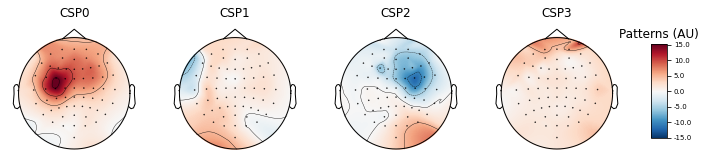

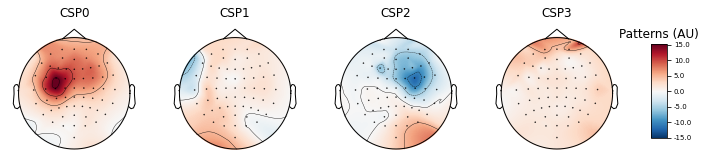

In [68]:
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

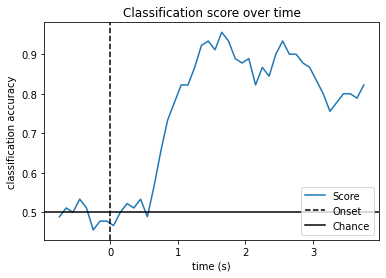

In [3]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()